In [14]:
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
# %config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
base_df = pd.read_csv("../Data/clinvar_conflicting.csv", dtype={"CHROM": "string", "MOTIF_NAME": "string", "HIGH_INF_POS": "string"})

In [3]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  string 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [10]:
# reduce the data frame and do some basic cleaning, start with just a few bare features

#     - CHROM, REF, ALT, AF_*, CLNVC, ORIGIN, CLASS, Allele, Consequence, IMPACT, STRAND
# reduced_df = base_df[['CHROM', 'REF', 'CLASS']]
reduced_df = base_df[['CHROM', 'CLASS']]

# fix chrom
reduced_df.loc[reduced_df['CHROM'] == 'X', 'CHROM'] = '23'
reduced_df.loc[reduced_df['CHROM'] == 'MT', 'CHROM'] = '24'
reduced_df["CHROM"] = pd.to_numeric(reduced_df["CHROM"])
# reduced_df["CHROM"] = reduced_df["CHROM"].astype(int)

print(reduced_df['CHROM'].unique())
print(reduced_df['CHROM'].value_counts())

# dropping MT rows (after it was converted to 24)
# reduced_df.drop(reduced_df[reduced_df['CHROM'] == 24].index, inplace=True)

# drop rows where REF is not one of the main 4 (for others there are not many rows, could maybe combine them though in the future somehow)
# main_alleles = ['C', 'G', 'A', 'T']
# reduced_df = reduced_df[reduced_df['REF'].isin(main_alleles)]

# print(reduced_df['REF'].nunique())
# with pd.option_context('display.max_rows', 2000):
#     print(reduced_df['REF'].value_counts())


print(reduced_df['CLASS'].unique())
print(reduced_df['CLASS'].value_counts())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
2     8645
17    5394
11    4846
1     4454
16    3927
19    3911
5     3643
7     2867
12    2750
9     2744
13    2646
3     2529
10    2341
6     2159
14    1974
23    1926
8     1852
15    1725
4     1206
22    1135
18     896
21     843
20     759
24      16
Name: CHROM, dtype: int64
[0 1]
0    48754
1    16434
Name: CLASS, dtype: int64


<ipython-input-10-48c254cc115f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["CHROM"] = pd.to_numeric(reduced_df["CHROM"])


In [11]:
# need to do one-hot-encoding of allele type to turn it into a useful variable
# or can maybe use Pandas built in functions, Pandas.Categorical...

# reduced_df.loc[:, 'REF'] = reduced_df['REF'].astype('category')

# print(reduced_df['REF'].nunique())
# print(reduced_df['REF'].value_counts())

In [12]:
df_train, df_test = train_test_split(reduced_df, test_size=0.2, random_state=42)

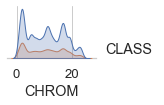

In [27]:
# sns.pairplot(df_train, corner=True, height=1.5, plot_kws={'size': 3}, hue='CLASS');
sns.pairplot(df_train, corner=True, height=1.5, plot_kws={'size': 3}, hue='CLASS');

<AxesSubplot:xlabel='CHROM', ylabel='Density'>

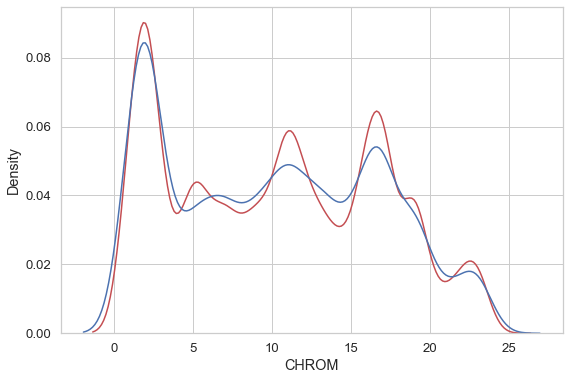

In [37]:
# sns.kdeplot(df_train['CHROM'], hue=df_train['CLASS'])
sns.kdeplot(df_train.loc[df_train['CLASS'] == 0, 'CHROM'], color='r')
sns.kdeplot(df_train.loc[df_train['CLASS'] == 1, 'CHROM'], color='b')

# reduced_df.loc[reduced_df['CHROM'] == 'MT', 'CHROM'] = '24'



In [15]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['CHROM']], df_train['CLASS'])

LogisticRegression(C=100000, solver='newton-cg')

In [16]:
print('intercept: ', round(lm_1.intercept_[0], 4))
print('chrom coef: ', round(lm_1.coef_[0][0], 4))

intercept:  -1.046
chrom coef:  -0.0039


In [17]:
df_eval = df_test.copy()
df_eval['pred'] = lm_1.predict(df_test[['CHROM']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['CLASS']

In [23]:
df_eval.info()
# df_eval.head(50)
df_eval['pred'].unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13038 entries, 49753 to 26310
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   CHROM         13038 non-null  int64   
 1   CLASS         13038 non-null  int64   
 2   pred          13038 non-null  category
 3   correct_pred  13038 non-null  bool    
dtypes: bool(1), category(1), int64(2)
memory usage: 971.1 KB


[0]
Categories (1, int64): [0]

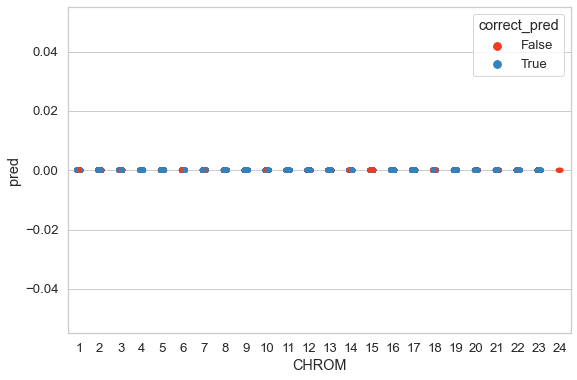

In [18]:
sns.stripplot(data=df_eval,
              x='CHROM',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});